<a href="https://colab.research.google.com/github/slala2121/Triplet-net-keras/blob/COS597D/deep_metric_learning_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code adapted from:
https://github.com/KinWaiCheuk/Triplet-net-keras

Other relevant links:

scratch classification network from https://keras.io/examples/cifar10_resnet/

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install --upgrade tensorflow
!pip install tensorflow-addons


     |████████████████████████████████| 86.3MB 37kB/s 
     |████████████████████████████████| 3.8MB 46.3MB/s 
     |████████████████████████████████| 450kB 38.0MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 380.8MB 39kB/s 


In [0]:
# current work around for fixing the lifted structure loss file

%%writefile /usr/local/lib/python3.6/dist-packages/tensorflow_addons/losses/lifted.py


# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Implements lifted_struct_loss."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow_addons.losses import metric_learning
from tensorflow_addons.utils import keras_utils


@keras_utils.register_keras_custom_object
@tf.function
def lifted_struct_loss(labels, embeddings, margin=1.0):
    """Computes the lifted structured loss.

    Args:
      labels: 1-D tf.int32 `Tensor` with shape [batch_size] of
        multiclass integer labels.
      embeddings: 2-D float `Tensor` of embedding vectors. Embeddings should
        not be l2 normalized.
      margin: Float, margin term in the loss definition.

    Returns:
      lifted_loss: tf.float32 scalar.
    """
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    lshape = tf.shape(labels)
    # assert lshape.shape == 1
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pairwise_distances = metric_learning.pairwise_distance(embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    batch_size = tf.size(labels)

    diff = margin - pairwise_distances
    mask = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    # Safe maximum: Temporarily shift negative distances
    #   above zero before taking max.
    #     this is to take the max only among negatives.
    row_minimums = tf.math.reduce_min(diff, 1, keepdims=True)
    row_negative_maximums = tf.math.reduce_max(
        tf.math.multiply(diff - row_minimums, mask), 1,
        keepdims=True) + row_minimums

    # Compute the loss.
    # Keep track of matrix of maximums where M_ij = max(m_i, m_j)
    #   where m_i is the max of alpha - negative D_i's.
    # This matches the Caffe loss layer implementation at:
    #   https://github.com/rksltnl/Caffe-Deep-Metric-Learning-CVPR16/blob/0efd7544a9846f58df923c8b992198ba5c355454/src/caffe/layers/lifted_struct_similarity_softmax_layer.cpp  # pylint: disable=line-too-long

    max_elements = tf.math.maximum(row_negative_maximums,
                                   tf.transpose(row_negative_maximums))
    diff_tiled = tf.tile(diff, [batch_size, 1])
    mask_tiled = tf.tile(mask, [batch_size, 1])
    max_elements_vect = tf.reshape(tf.transpose(max_elements), [-1, 1])

    loss_exp_left = tf.reshape(
        tf.math.reduce_sum(
            tf.math.multiply(
                tf.math.exp(diff_tiled - max_elements_vect), mask_tiled),
            1,
            keepdims=True), [batch_size, batch_size])

    loss_mat = max_elements + tf.math.log(loss_exp_left +
                                          tf.transpose(loss_exp_left))
    # Add the positive distance.
    loss_mat += pairwise_distances

    mask_positives = tf.cast(
        adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
            tf.ones([batch_size]))

    # *0.5 for upper triangular, and another *0.5 for 1/2 factor for loss^2.
    num_positives = tf.math.reduce_sum(mask_positives) / 2.0

    lifted_loss = tf.math.truediv(
        0.25 * tf.math.reduce_sum(
            tf.math.square(
                tf.math.maximum(
                    tf.math.multiply(loss_mat, mask_positives), 0.0))),
        num_positives)
    return lifted_loss


@keras_utils.register_keras_custom_object
class LiftedStructLoss(tf.keras.losses.Loss):
    """Computes the lifted structured loss.

    The loss encourages the positive distances (between a pair of embeddings
    with the same labels) to be smaller than any negative distances (between
    a pair of embeddings with different labels) in the mini-batch in a way
    that is differentiable with respect to the embedding vectors.
    See: https://arxiv.org/abs/1511.06452.

    Args:
      margin: Float, margin term in the loss definition.
      name: Optional name for the op.
    """

    def __init__(self, margin=1.0, name=None):
        super(LiftedStructLoss, self).__init__(
            name=name, reduction=tf.keras.losses.Reduction.NONE)
        self.margin = margin

    def call(self, y_true, y_pred):
        return lifted_struct_loss(y_true, y_pred, self.margin)

    def get_config(self):
        config = {
            "margin": self.margin,
        }
        base_config = super(LiftedStructLoss, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [0]:
import os
os.kill(os.getpid(), 9)

In [0]:
import time
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import random
from itertools import permutations
from PIL import Image

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers

from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_addons as tfa


source_path=os.path.join('drive','My Drive', 'Colab Notebooks')


In [0]:
# prepare dataset either for classification or deep metric learning
import tensorflow_datasets as tfds

dataset_name='cifar10'

loss_type='classification'
DATA_AUGMENTATIONS=True
BATCH_SIZE=10


dataset_dir=os.path.join(source_path,dataset_name)
if not os.path.isdir(dataset_dir):
  os.mkdir(dataset_dir)

debug=1

if debug:
  split_percent=1
  train_split = tfds.Split.TRAIN.subsplit(tfds.percent[:split_percent])
  test_split = tfds.Split.TEST.subsplit(tfds.percent[:split_percent])
  train_dataset,info = tfds.load(name=dataset_name, split=train_split, as_supervised=True, with_info=True)
  test_dataset,info = tfds.load(name=dataset_name, split=test_split, as_supervised=True, with_info=True)
else:
  train_dataset,info = tfds.load(name=dataset_name, split='train', as_supervised=True, with_info=True)
  test_dataset,info = tfds.load(name=dataset_name, split='test', as_supervised=True, with_info=True)

input_dim=info.features['image'].shape
num_classes=info.features['label'].num_classes
num_train_images=info.splits['train'].num_examples
num_test_images=info.splits['test'].num_examples

train_mean_path=os.path.join(dataset_dir,'train_mean.npy')
if os.path.exists(train_mean_path):
  train_mean=np.load(train_mean_path)
else:
  train_mean=[]
  train_mean=[]
  for example in train_dataset.take(num_train_images):
    image,label=example[0],example[1]
    image=image.numpy().astype('float32')
    if len(train_mean)==0:
      train_mean=image
    else:
      train_mean = train_mean+image

  train_mean=train_mean*1.0/num_train_images
  np.save(train_mean_path,train_mean)


# prepare dataset either for classification or deep metric learning

def _normalize_img(img, label):
    img = img - train_mean
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)


# preprocessing of labels for classification

def _encode_one_hot(img, label):
    label = tf.one_hot(label,num_classes)
    return (img, label)


# Build your input pipelines
# preprocessing


if loss_type=='classification':
  train_dataset = train_dataset.map(_encode_one_hot)
  test_dataset = test_dataset.map(_encode_one_hot)


train_dataset=train_dataset.map(
    lambda image,label: (image-train_mean,label)
).cache().map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)
)

test_dataset=test_dataset.map(
      lambda image,label: (image-train_mean,label)
).cache().map(
      lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)
)



if DATA_AUGMENTATIONS:
  new_input_dim=(32,32,3)
  CROP_SIZE=tf.convert_to_tensor(list(new_input_dim)) 
  train_dataset=train_dataset.map(
      lambda image, label: (tf.image.random_flip_left_right(image), label)
  ).map(
      lambda image, label: (tf.image.random_crop(image,CROP_SIZE), label)
  )

train_dataset=train_dataset.shuffle(100).batch(BATCH_SIZE)
test_dataset=test_dataset.batch(1)


In [0]:
# prepare dataset either for classification or deep metric learning
import tensorflow_datasets as tfds

dataset_name='caltech_birds2011'

loss_type='lifted'
DATA_AUGMENTATIONS=True
BATCH_SIZE=128

debug=1


dataset_dir=os.path.join(source_path,dataset_name)
if not os.path.isdir(dataset_dir):
  os.mkdir(dataset_dir)


train_dataset,info = tfds.load(name=dataset_name, split='train', as_supervised=True, with_info=True)
test_dataset,info = tfds.load(name=dataset_name, split='test', as_supervised=True, with_info=True)

input_dim=info.features['image'].shape
num_classes=info.features['label'].num_classes

# prepare dataset either for classification or deep metric learning

def _normalize_img(img, label):
    img = img - train_mean
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)


# preprocessing of labels for classification

def _encode_one_hot(img, label):
    label = tf.one_hot(label,num_classes)
    return (img, label)


# Build your input pipelines
# preprocessing


if loss_type=='classification':
  train_dataset = train_dataset.map(_encode_one_hot)
  test_dataset = test_dataset.map(_encode_one_hot)


# separating the dataset based on classes
combined_dataset=train_dataset.concatenate(test_dataset)
train_classes=np.arange(100)
train_dataset=combined_dataset.filter(lambda image,label: label < 100)
test_classes=np.arange(100,200)
test_dataset=combined_dataset.filter(lambda image,label: label >= 100)

train_dataset=train_dataset.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)
).cache().map(
    lambda image,label: (tf.image.resize(image, [256, 256]),label)
).cache()

test_dataset=test_dataset.map(
      lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)
).cache().map(
      lambda image,label: (tf.image.resize(image, [256, 256]),label)
).cache()


if DATA_AUGMENTATIONS:
  new_input_dim=(227,227,3)
  CROP_SIZE=tf.convert_to_tensor(list(new_input_dim)) 
  train_dataset=train_dataset.map(
      lambda image, label: (tf.image.random_flip_left_right(image), label)
  ).map(
      lambda image, label: (tf.image.random_crop(image,CROP_SIZE), label)
  )


train_dataset=train_dataset.shuffle(100).batch(BATCH_SIZE)
test_dataset=test_dataset.batch(1)

if debug:
  train_dataset=train_dataset.take(20)
  test_dataset=test_dataset.take(20)
  BATCH_SIZE=10


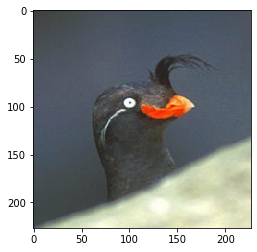

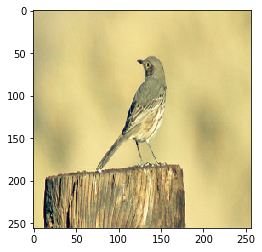

In [3]:
image,label=next(iter(train_dataset))
plt.figure()
plt.imshow(image[0])

image,label=next(iter(test_dataset))
plt.figure()
plt.imshow(image[0])

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# based on the lifted scheme paper
def create_deep_base_network(input_dim,loss_type,num_classes=0,transfer=False,freeze_weights=False):
  weights='imagenet' if transfer else None
  conv_base = ResNet50(weights=weights, include_top=False, input_shape=input_dim)

  if freeze_weights:
    for layer in conv_base.layers:
      layer.trainable=False
  
  model = models.Sequential()
  model.add(layers.Input(input_dim))
  model.add(conv_base)

  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())

  if loss_type=='classification':
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
  else:
    model.add(layers.Dense(64, activation=None))
    model.add(layers.Dropout(0.5))

  return model


def create_shallow_network(input_dim,loss_type,num_classes=0):
  model=tf.keras.Sequential()
  model.add(layers.Input(input_dim))
  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.BatchNormalization())

  if loss_type=='classification':
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(num_classes,activation='softmax'))
  else:
    model.add(tf.keras.layers.Dense(256, activation=None))
    model.add(tf.keras.layers.Dropout(0.5))

  return model

def construct_model(model_type,input_dim,loss_type,num_classes,transfer=False,freeze_weights=False):
  if model_type=='shallow':
    model=create_shallow_network(input_dim,loss_type,num_classes)
  elif model_type=='deep':
    model=create_deep_base_network(input_dim,loss_type,num_classes,transfer,freeze_weights)

  if loss_type =='triplet':
    model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
  return model

def construct_loss(loss_type,margin):
  if loss_type=='triplet':
    loss=tfa.losses.TripletSemiHardLoss(margin=margin)
  elif loss_type=='lifted':
    loss=tfa.losses.LiftedStructLoss(margin=margin)
  elif loss_type=='classification':
    loss=tf.keras.losses.CategoricalCrossentropy()
  return loss

In [0]:
# tune lr

lrs=[1e-4,1e-5,1e-6]
# lrs=[1e-6]
model_type='deep'
transfer=True
freeze_weights=False

margin=1.0

model_dir=os.path.join(dataset_dir,model_type)
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

num_epochs=30

fig,ax=plt.subplots(2,3)
ax=ax.ravel()
for lr_index,lr in enumerate(lrs):
  model=construct_model(model_type,new_input_dim,loss_type,num_classes,transfer,freeze_weights)
  loss=construct_loss(loss_type,margin)

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(lr),loss=loss)

  history = model.fit(
      train_dataset,
      epochs=num_epochs)

  ax[lr_index].set_title('Loss for lr_%s'%(str(lr)))
  ax[lr_index].plot(np.arange(num_epochs),history.history['loss'],'r',label='train_loss_lr_%s'%(str(lr)))
  
plt.legend()
plt.savefig(os.path.join(model_dir,'loss_plot_lr_tune_%s_transfer_%s_freeze_%s_%s_%s.png'%(model_type,transfer,freeze_weights,loss_type,margin)))
plt.close()

Epoch 1/30
      6/Unknown - 18s 3s/step - loss: 49.1870

In [18]:
# train model

lr=1e-3

model_type='deep'
transfer=True
freeze_weights=False

margin=1.0

model_dir=os.path.join(dataset_dir,model_type)
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

num_epochs=1

model=construct_model(model_type,input_dim,loss_type,num_classes,transfer,freeze_weights)
loss=construct_loss(loss_type,margin)

# Compile the model
metrics=[]
if loss_type=='classification':
  metrics=['accuracy']
model.compile(optimizer=tf.keras.optimizers.Adam(lr),loss=loss,metrics=metrics)

# Prepare callbacks for model saving and for learning rate adjustment.
filepath=os.path.join(model_dir,'final_%s_%s_transfer_%s_freeze_%s_margin_%s.h5'%(loss_type,model_type,transfer,freeze_weights,margin))
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint]

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    callbacks=callbacks)


plt.figure()
plt.plot(np.arange(num_epochs),history.history['loss'],'r',label='train_loss')
plt.plot(np.arange(num_epochs),history.history['val_loss'],'b',label='val_loss')
plt.legend()
filepath=os.path.join(model_dir,'final_loss_plot_%s_%s_transfer_%s_freeze_%s_margin_%s.png'%(loss_type,model_type,transfer,freeze_weights,margin))
plt.savefig(filepath)
plt.close()

     50/Unknown - 13s 263ms/step - loss: 2.7228 - accuracy: 0.1320
Epoch 00001: val_loss improved from inf to 19.35395, saving model to drive/My Drive/Colab Notebooks/cifar10/deep/final_classification_deep_transfer_True_freeze_False_margin_1.0.h5
50/50 [==============================] - 18s 351ms/step - loss: 2.7228 - accuracy: 0.1320 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [0]:
# evaluate performance of model using Recall@K

# retrieve k nearest neighbors based on embeddings


# pairwise distance matrix computation: 
# https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow


@tf.function
def forward(A):
  r = tf.reduce_sum(A*A, 1)
  r = tf.reshape(r, [-1, 1])
  D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
  return D
# A = tf.constant([[1, 1], [2, 2], [3, 3]])
# res=forward(A)
# print(res)


"""
D: 2d array num_samplesxnum_samples (num_samples >=2)
test_labels: 1d array num_samples
k: int # nearest neighbors >=1
"""
def compute_recall_at_k(D,test_labels,k):
  num_samples=D.shape[0]
  recall=0

  for sample_index in range(num_samples):
    ind_samples_sorted_by_distance=np.argsort(D[sample_index])
    # assert ind_samples_sorted_by_distance[0]==sample_index
    ind_samples_sorted_by_distance=ind_samples_sorted_by_distance[1:]# exclude the sample in question
    
    ind_nearest_k_neighbors=ind_samples_sorted_by_distance[:k]
    labels_nearest_k_neighbors=test_labels[ind_nearest_k_neighbors]
    true_label=test_labels[sample_index]

    if true_label in labels_nearest_k_neighbors:
      recall+=1

  recall*=(1.0/num_samples)

  return recall




# test compute_recall_at_k

# recall = 1, recall < 1
from sklearn.datasets import make_spd_matrix
np.random.seed(15)
num_samples=6
D=make_spd_matrix(num_samples)
D=np.abs(D)
for i in range(num_samples):
  D[i,i]=0

test_labels=np.random.randint(0,3,size=num_samples)
test_labels[-1]=1

recall_score=compute_recall_at_k(D,test_labels,k=num_samples)
assert np.allclose(recall_score,1.0)

recall_score=compute_recall_at_k(D,test_labels,k=1)
assert np.allclose(recall_score,1./6)

recall_score=compute_recall_at_k(D,test_labels,k=2)
assert np.allclose(recall_score,2./3)

recall_score=compute_recall_at_k(D,test_labels,k=3)
assert np.allclose(recall_score,2./3)

recall_score=compute_recall_at_k(D,test_labels,k=4)
assert np.allclose(recall_score,1.0)

recall_score=compute_recall_at_k(D,test_labels,k=5)
assert np.allclose(recall_score,1.0)






In [8]:
# evaluate performance

embeddings_layer_model=models.Model(inputs=model.input,outputs=model.layers[-4].output)
predictions=embeddings_layer_model.predict(test_dataset)

# computes pairwise distance between the rows of predictions
D=forward(predictions)
num_test_samples=D.shape[0]

Ks=[]
recall_by_k=[]
for k in Ks:
  recall_at_k=compute_recall_at_k(D,test_labels,k) 
  recall_by_k.append(recall_at_k)
recall_by_k=np.array(recall_by_k)

NameError: ignored